<a href="https://colab.research.google.com/github/tuongkhangduongle/brainMRI_segmentation/blob/main/resunet_formedical_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Jun 27 14:33:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   8922MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/REPORT/CourseProject/CS338/archive.zip' '/content/archive.zip'

In [ ]:
!unzip -q './archive.zip'

#Lib


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

# Read dataset

In [ ]:
data = pd.read_csv('./lgg-mri-segmentation/kaggle_3m/data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
data.head(7)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0


In [ ]:
data_map = []
for sub_dir_path in glob.glob("./lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: './lgg-mri-segmentation/kaggle_3m/data.csv'
[Errno 20] Not a directory: './lgg-mri-segmentation/kaggle_3m/README.md'


In [ ]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_HT_8114_19981030,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...
1,TCGA_HT_8114_19981030,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...
2,TCGA_HT_8114_19981030,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...
3,TCGA_HT_8114_19981030,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...
4,TCGA_HT_8114_19981030,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...


In [ ]:
df_imgs = df[~df['path'].str.contains("mask.nii.gz")]
df_masks = df[df['path'].str.contains("mask.nii.gz")]
print("Path to the Image:", df_imgs, "\nPath to the Mask:", df_masks)

Path to the Image:                  patient_id                                               path
0     TCGA_HT_8114_19981030  ./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...
1     TCGA_HT_8114_19981030  ./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...
2     TCGA_HT_8114_19981030  ./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...
3     TCGA_HT_8114_19981030  ./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...
4     TCGA_HT_8114_19981030  ./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...
...                     ...                                                ...
7853  TCGA_FG_7643_20021104  ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_...
7854  TCGA_FG_7643_20021104  ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_...
7855  TCGA_FG_7643_20021104  ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_...
7856  TCGA_FG_7643_20021104  ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_...
7857  TCGA_FG_7643_20021104  ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_...

[7858 rows x 2 columns] 
Path to

In [ ]:
len('./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_')

77

In [ ]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 77 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_3.tif 
Path to the Mask: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_3_mask.tif


In [ ]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_HT_8114_19981030,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_...,0
1,TCGA_HT_8114_19981030,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6692_...,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6692_...,0
2,TCGA_HT_8114_19981030,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7684_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7684_...,0
3,TCGA_HT_8114_19981030,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_...,0
4,TCGA_HT_8114_19981030,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_...,0
...,...,...,...,...
3924,TCGA_FG_7643_20021104,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_...,0
3925,TCGA_FG_7643_20021104,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_...,0
3926,TCGA_FG_7643_20021104,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_...,0
3927,TCGA_FG_7643_20021104,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_...,0


# Data visualization

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, 
                        y=brain_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

# Pre-processing

In [ ]:
gamma = 1.2
inverse_gamma = 1.0 / gamma
look_up_table = np.array([((i/255.0) ** inverse_gamma) * 255.0 for i in np.arange(0,256,1)]).astype("uint8")
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def contrast_enhancement(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    img[:,:,0] = clahe.apply(img[:,:,0])
    img = cv2.cvtColor(img, cv2.COLOR_LUV2RGB)
    return img

In [ ]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15, random_state = 42)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=8,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
brain_df_mask.to_csv('brain_df_mask.csv')

In [ ]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15, random_state = 42)
X_test, X_val = train_test_split(X_val, test_size=0.5, random_state = 42)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 8, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)
      #img = contrast_enhancement(img)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

# Model Res-Unet

In [ ]:
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [ ]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_26[0][0]     
____________________________________________________________________________________________

# VGG19-Unet

In [ ]:
from tensorflow.keras.applications import VGG19

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         
    s2 = vgg19.get_layer("block2_conv2").output         
    s3 = vgg19.get_layer("block3_conv4").output         
    s4 = vgg19.get_layer("block4_conv4").output         

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model
model_vgg19 = build_vgg19_unet((256,256,3))
model_vgg19.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
________________________________________________________________________________________

# Custom Loss Function

In [ ]:
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)

    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    return 1 - tversky(y_true,y_pred)

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)

    return (( (2. * intersection) + smooth ) / (total + smooth) )
def dice_coef_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    #y_pred = tf.cast(y_pred, tf.float32)
    return 1-dice_coef(y_true, y_pred)

def diceBCE_loss(y_true, y_pred):
    smooth = 1e-6

    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)

    dice_coef_sc = dice_coef_loss(y_true, y_pred)
    BCE =  tf.keras.losses.binary_crossentropy(targets, inputs)
    
    return BCE + dice_coef_sc

In [ ]:
def iou(y_true, y_pred):
    smooth = 1e-6
    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)

    intersection = K.sum(inputs*targets)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection

    return (intersection + smooth)/(union+smooth)

def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)

    return 1 - iou(y_true, y_pred)

# Training Model

## Res-Unet

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = tversky_loss, 
                  metrics = [iou]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="bcedice-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
h = seg_model.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/60
72/72 [==============================] - 48s 184ms/step - loss: 0.8030 - iou: 0.0707 - val_loss: 0.8049 - val_iou: 0.0777

Epoch 00001: val_loss improved from inf to 0.80489, saving model to bcedice-weights.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/60
72/72 [==============================] - 13s 175ms/step - loss: 0.4657 - iou: 0.3197 - val_loss: 0.4515 - val_iou: 0.3333

Epoch 00002: val_loss improved from 0.80489 to 0.45154, saving model to bcedice-weights.hdf5
Epoch 3/60
72/72 [==============================] - 13s 177ms/step - loss: 0.2926 - iou: 0.5184 - val_loss: 0.4493 - val_iou: 0.2833

Epoch 00003: val_loss improved from 0.45154 to 0.44929, saving model to bcedice-weights.hdf5
Epoch 4/60
72/72 [==============================] - 13s 178ms/step - loss: 0.2363 - iou: 0.5889 - val_loss: 0.2786 - val_iou: 0.5091

Epoch 00004: val_loss improved from 0.44929 to 0.27861, saving model to bcedice-weights.hdf5
Epoch 5/60
72/72 [==============================] - 13s 180ms/step - loss: 0.2114 - iou: 0.6186 - val_loss: 0.3883 - val_iou: 0.4996

Epoch 00005: val_loss did not improve from 0.27861
Epoch 6/60
72/72 [==============================] - 13s 182ms/step - loss: 0.1791 - iou: 0.6649 - val_loss: 0.3042 - val_iou: 0.4284



In [ ]:
h.history.keys()

dict_keys(['loss', 'iou', 'val_loss', 'val_iou', 'lr'])

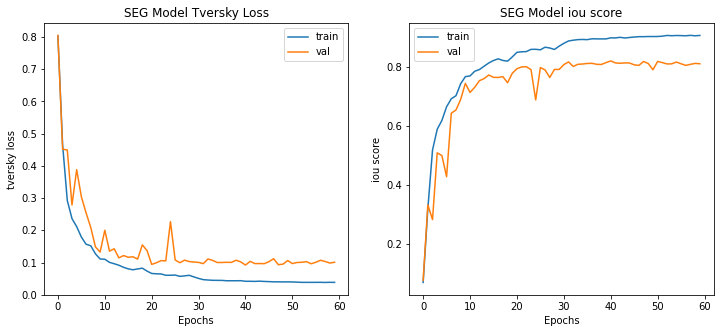

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model Tversky Loss");
plt.ylabel("tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['iou']);
plt.plot(h.history['val_iou']);
plt.title("SEG Model iou score");
plt.ylabel("iou score");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
!cp './bcedice-weights.hdf5' '/content/drive/MyDrive/REPORT/bcedice-weights.hdf5'

## VGG19-Unet

In [ ]:
# compling model and callbacks functions
#sgd = tf.keras.optimizers.SGD(lr = 0.01, momentum= 0.9)
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_vgg19.compile(optimizer = adam, 
                  loss = iou_loss, #bce_dice tverskyloss 
                  metrics = [iou]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weight_unet_diceBCE_adam_model.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
h_vgg19 = model_vgg19.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/60
145/145 [==============================] - 80s 536ms/step - loss: 0.7664 - iou: 0.2336 - val_loss: 0.5764 - val_iou: 0.4236

Epoch 00001: val_loss improved from inf to 0.57643, saving model to weight_unet_diceBCE_adam_model.h5
Epoch 2/60
145/145 [==============================] - 77s 530ms/step - loss: 0.5598 - iou: 0.4402 - val_loss: 0.5453 - val_iou: 0.4547

Epoch 00002: val_loss improved from 0.57643 to 0.54528, saving model to weight_unet_diceBCE_adam_model.h5
Epoch 3/60
145/145 [==============================] - 77s 528ms/step - loss: 0.5204 - iou: 0.4796 - val_loss: 0.4976 - val_iou: 0.5024

Epoch 00003: val_loss improved from 0.54528 to 0.49762, saving model to weight_unet_diceBCE_adam_model.h5
Epoch 4/60
145/145 [==============================] - 76s 524ms/step - loss: 0.4776 - iou: 0.5224 - val_loss: 0.6105 - val_iou: 0.3895

Epoch 00004: val_loss did not improve from 0.49762
Epoch 5/60
145/145 [==============================] - 76s 524ms/step - loss: 0.4606 - iou: 

In [ ]:
h_vgg19.history.keys()

dict_keys(['loss', 'iou', 'val_loss', 'val_iou', 'lr'])

In [ ]:
!cp '/content/weight_unet_diceBCE_adam_model.h5' '/content/drive/MyDrive/REPORT/CourseProject/Advanced Computer Vision/weight_unet_diceBCE_adam_model.h5'

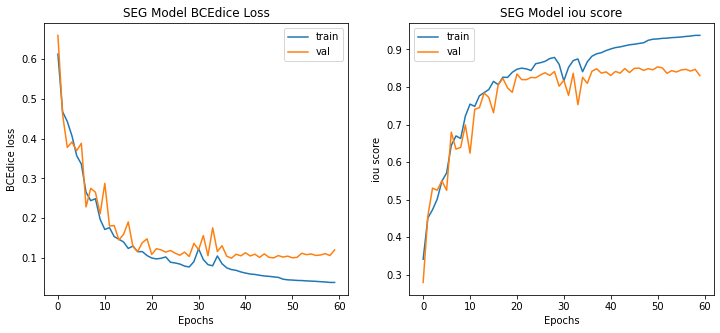

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h_vgg19.history['loss']);
plt.plot(h_vgg19.history['val_loss']);
plt.title("SEG Model BCEdice Loss");
plt.ylabel("BCEdice loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h_vgg19.history['iou']);
plt.plot(h_vgg19.history['val_iou']);
plt.title("SEG Model iou score");
plt.ylabel("iou score");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

# Evaluate()

## Res-Unet 

In [ ]:
model_dir = '/content/drive/MyDrive/REPORT/ResUNet-segModel-weights.hdf5'

In [ ]:
seg_model = load_model(model_dir,custom_objects={"focal_tversky":focal_tversky,"iou":iou,"focal_tversky_loss":focal_tversky})

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 1s 84ms/step - loss: 0.1217 - iou: 0.7825
Segmentation tversky is 78.25%


In [ ]:
def prediction(test, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        predict = model_seg.predict(X)
       

        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [ ]:
# making prediction
df_pred = prediction(test,seg_model)
df_pred

,image_path,predicted_mask,has_mask
0,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_...,"[[[[4.6640505e-08], [1.647099e-08], [1.4483983...",1
1,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_...,No mask :),0
2,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_...,No mask :),0
3,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_...,No mask :),0
4,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6692_...,"[[[[4.950162e-08], [1.7265434e-08], [1.4984625...",1
...,...,...,...
585,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_8168_...,No mask :),0
586,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_...,No mask :),0
587,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_...,No mask :),0
588,./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_...,"[[[[5.0211764e-08], [1.762646e-08], [1.5129714...",1


In [ ]:
# merging original and prediction df
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

,image_path,mask_path,mask,predicted_mask,has_mask
0,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_...,0,"[[[[4.6640505e-08], [1.647099e-08], [1.4483983...",1
1,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_...,0,No mask :),0
2,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_...,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_...,1,No mask :),0
3,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_...,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_...,0,No mask :),0
4,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6692_...,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6692_...,0,"[[[[4.950162e-08], [1.7265434e-08], [1.4984625...",1
5,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_...,1,No mask :),0
6,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_...,1,"[[[[4.921505e-08], [1.6688968e-08], [1.5004103...",1
7,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_...,1,No mask :),0
8,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_...,1,"[[[[4.5021473e-08], [1.5953333e-08], [1.418653...",1
9,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_...,0,No mask :),0


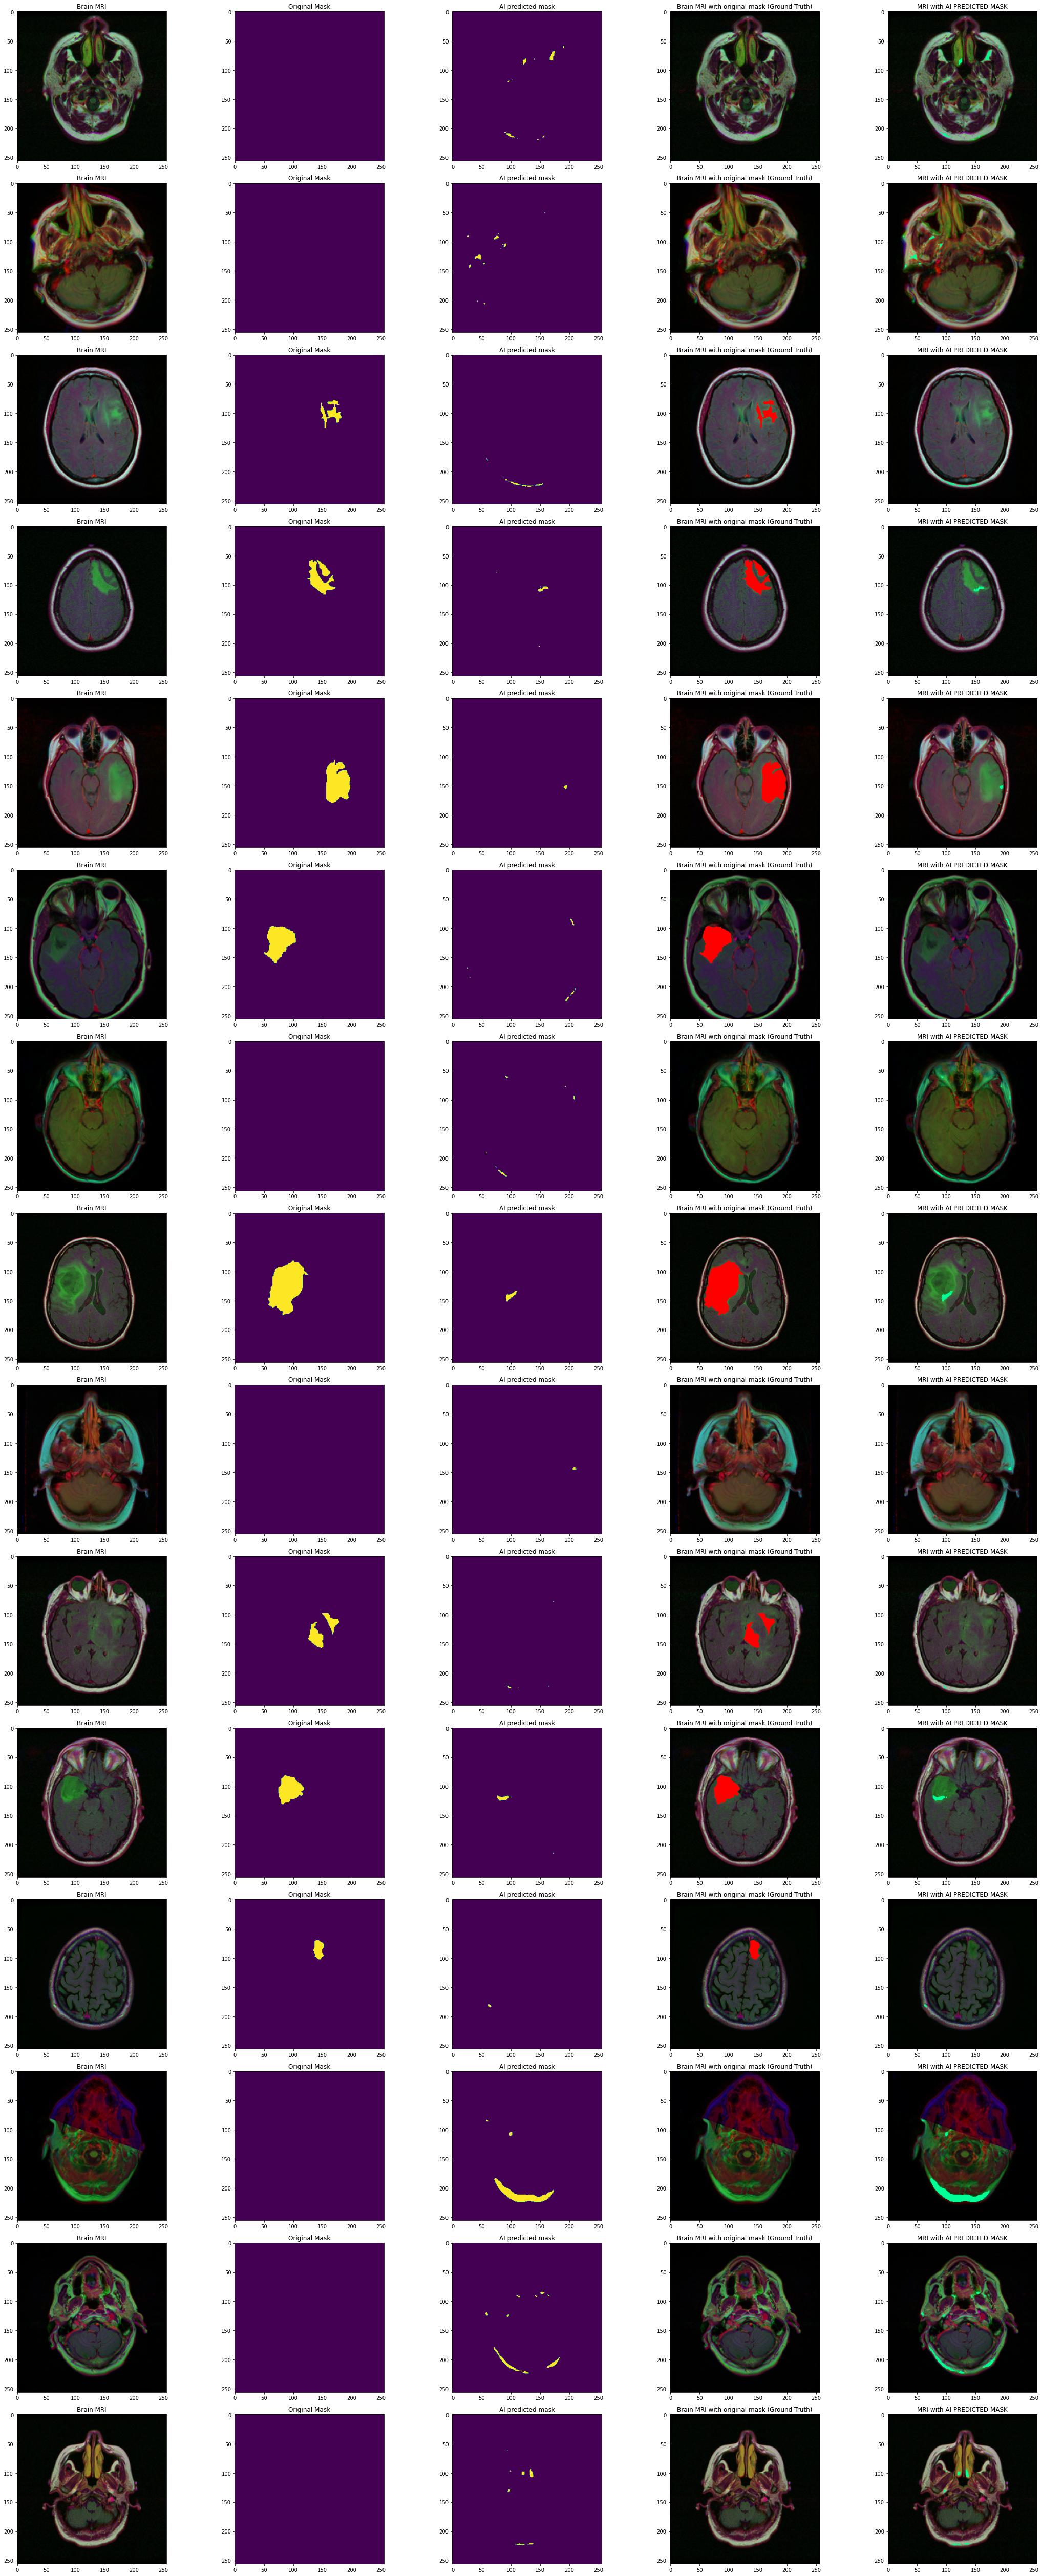

In [ ]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()    

## VGG19-Unet

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = model_vgg19.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

12/12 [==============================] - 2s 176ms/step - loss: 0.1158 - iou: 0.8435
Segmentation tversky is 84.35%


Load weight

In [ ]:
df_pred = prediction(test,model_vgg19)
df_pred

,image_path,predicted_mask,has_mask
0,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...,"[[[[0.00020891], [1.2156335e-05], [1.6297154e-...",1
1,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...,No mask :),0
2,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_...,No mask :),0
3,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7884_...,"[[[[0.00023665], [1.5537938e-05], [2.0401923e-...",1
4,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_...,"[[[[0.00019401], [1.0490282e-05], [1.5424199e-...",1
...,...,...,...
585,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_...,"[[[[0.00021476], [3.0267378e-05], [8.781547e-0...",1
586,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_...,"[[[[0.00040043], [4.919196e-05], [6.887871e-05...",1
587,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_...,"[[[[0.00020651], [1.164705e-05], [1.6012578e-0...",1
588,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_...,No mask :),0


In [ ]:
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

,image_path,mask_path_x,mask_x,mask_path_y,mask_y,predicted_mask,has_mask
0,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...,0,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...,0,"[[[[0.00020891], [1.2156335e-05], [1.6297154e-...",1
1,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...,0,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...,0,No mask :),0
2,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_...,0,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_...,0,No mask :),0
3,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7884_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7884_...,1,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7884_...,1,"[[[[0.00023665], [1.5537938e-05], [2.0401923e-...",1
4,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_...,1,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_...,1,"[[[[0.00019401], [1.0490282e-05], [1.5424199e-...",1
5,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_...,1,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_...,1,"[[[[0.0001428], [6.183565e-06], [1.4363123e-05...",1
6,./lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_...,./lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_...,0,./lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_...,0,No mask :),0
7,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_...,0,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_...,0,No mask :),0
8,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_...,1,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_...,1,"[[[[0.00021645], [1.3104305e-05], [1.694265e-0...",1
9,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_...,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_...,0,./lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_...,0,No mask :),0


AttributeError: ignored

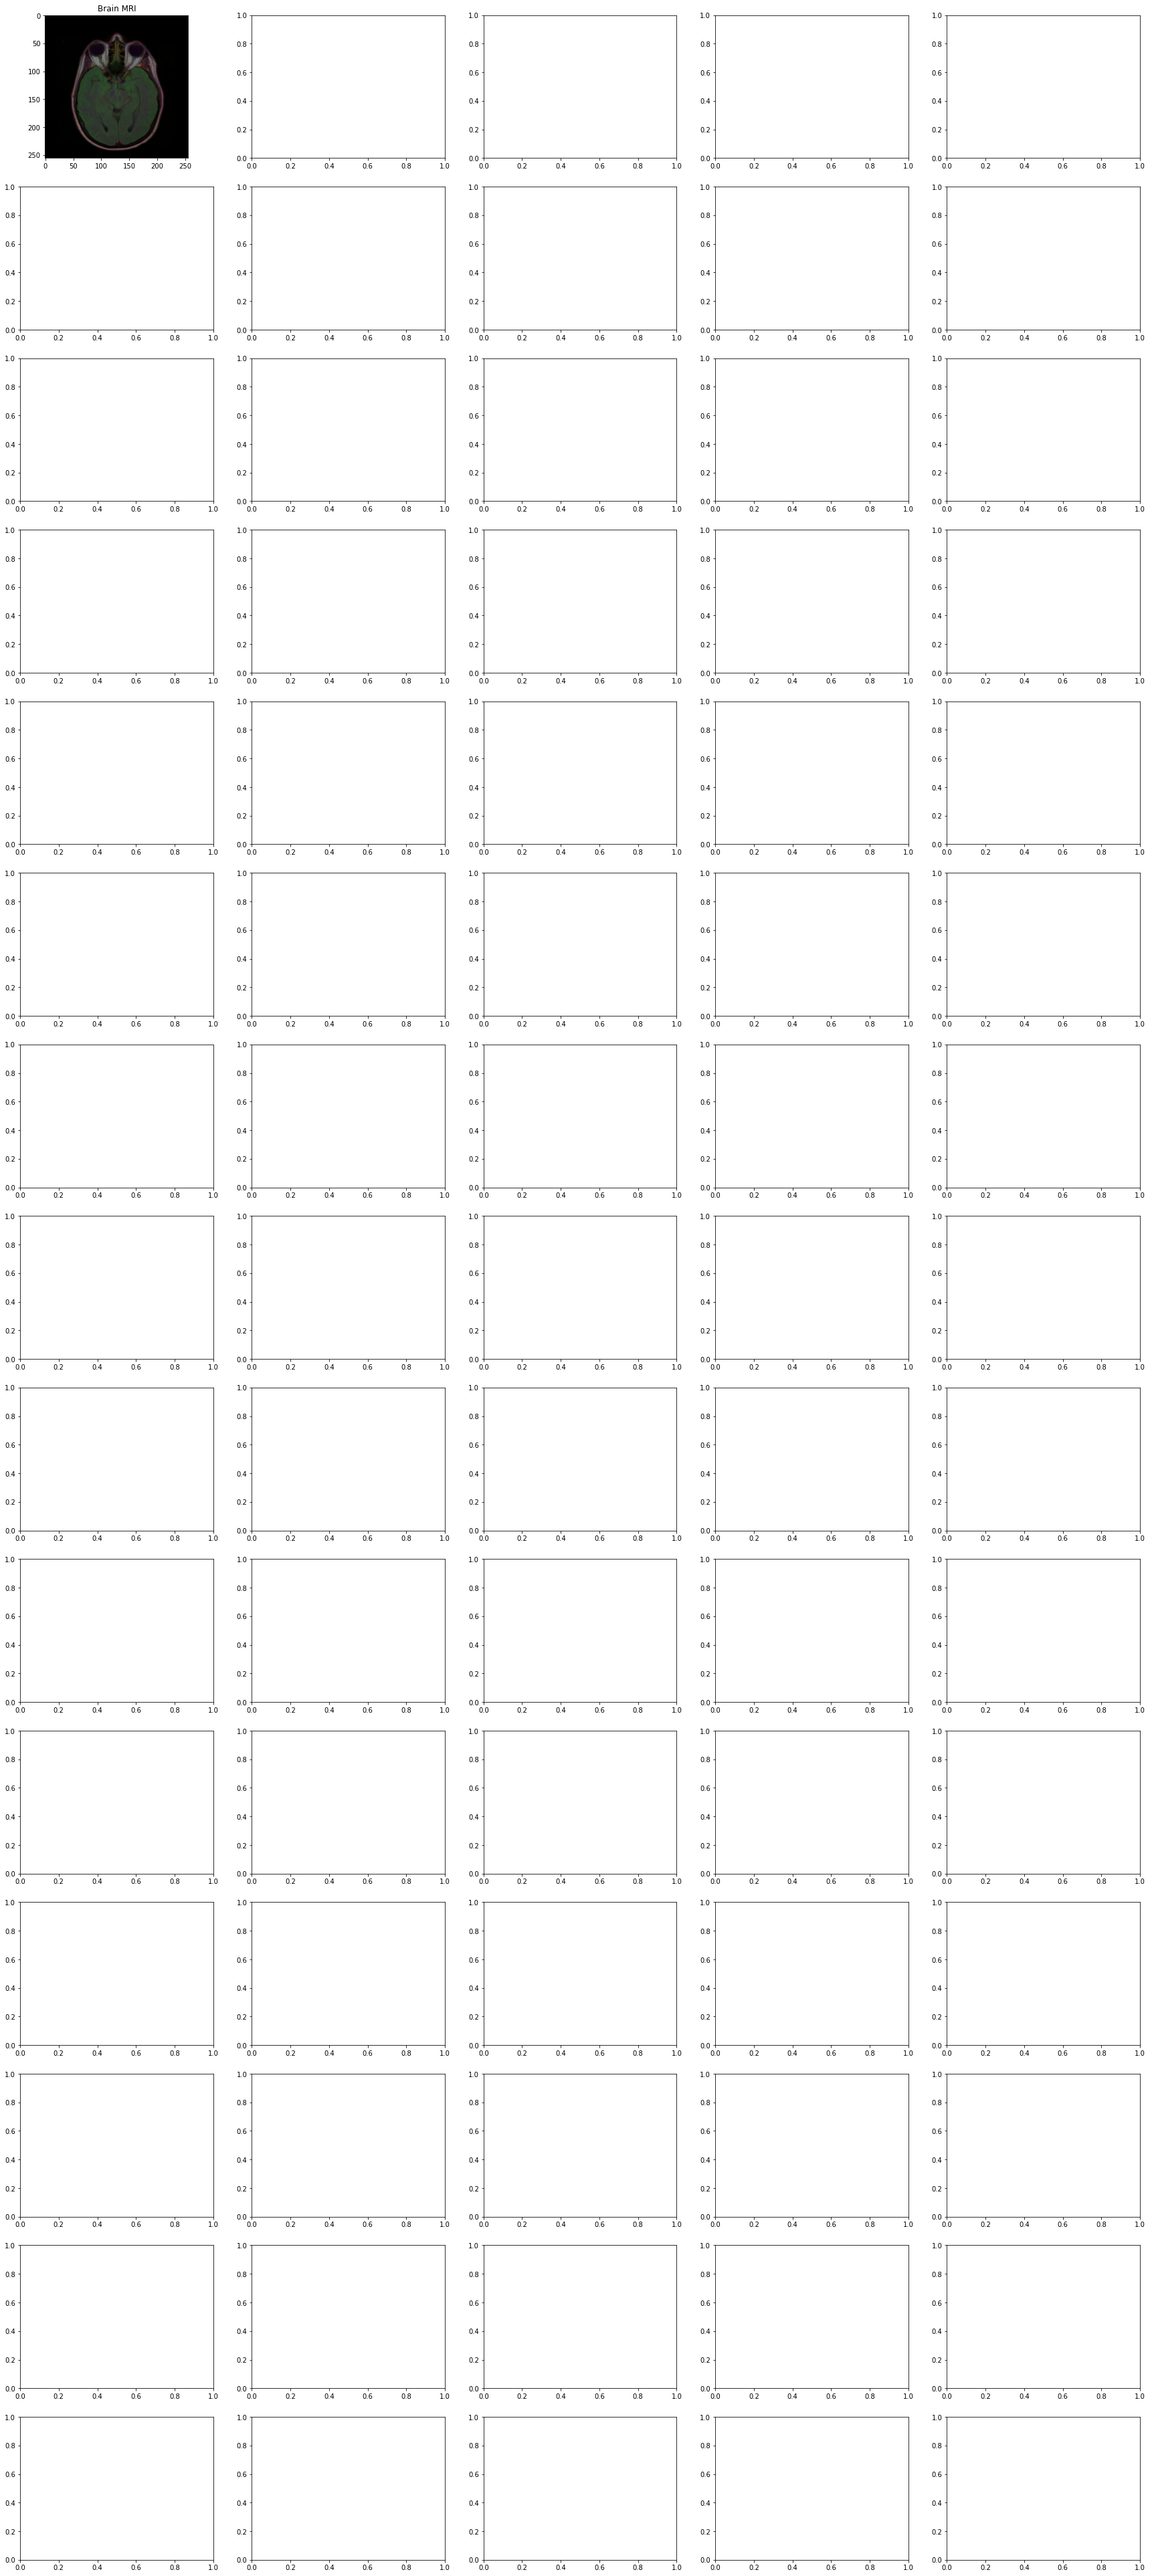

In [ ]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()  